# Road Segmentation using U-Net

This project focuses on segmenting road areas from images captured in challenging conditions (such as rainy or nighttime environments) using a **U-Net** architecture. The segmentation task is formulated as a binary classification problem where roads are labeled as "1" and the background as "0". The dataset is processed using **Roboflow** for annotation and training, with the final goal of producing an accurate road segmentation model.

### Steps Involved

1. **Install Libraries**  
   Install the necessary libraries for data processing, model training, and annotation handling.

2. **Download Dataset**  
   Using the **Roboflow API**, the dataset is downloaded in the **COCO format**, which includes both images and the corresponding segmentation annotations (roads vs. background).

3. **Process Images and Masks**  
   The COCO annotations are used to generate binary masks for each image, where roads are marked as '1' and background as '0'. Both images and masks are saved for future model training.

4. **Load Data**  
   The processed images and masks are loaded, resized to a target size (256x256), and normalized for model input.

5. **Split Data**  
   The dataset is split into **training** and **validation** sets to ensure proper model evaluation.

6. **Define U-Net Model**  
   A **U-Net architecture** is defined for image segmentation, consisting of a contracting and expansive path with skip connections. The output is a probability map for road vs. non-road areas.

7. **Compile and Train Model**  
   The model is compiled using the **Adam optimizer** and **binary cross-entropy loss**, and trained on the prepared dataset for up to 50 epochs.

8. **Visualize Results**  
   After training, the model’s **accuracy** and **loss** over the epochs are visualized to assess performance.

### Project Relevance  
The goal is to build a model capable of segmenting roads from images under varying lighting and weather conditions, which is crucial for autonomous driving systems and other computer vision applications related to road detection.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading Roboflow workspace...
loading Roboflow project...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Checking for mask at: /content/processed_masks/frame_00022_png.rf.8905483a92281d8be51e71fb2863529b_mask_mask.png
Checking for mask at: /content/processed_masks/frame_00030_png.rf.e08d779520bdb8ab85f148681cdd5650_mask_mask.png
Checking for mask at: /content/processed_masks/frame_00007_png.rf.942671855650203bc231c5d2a00be296_mask_mask.png
Checking for mask at: /content/processed_masks/frame_00013_png.rf.076a86ba5f9ac5c9fdb21673d902c850_mask_mask.png
Checking for mask at: /content/processed_masks/frame_00042_png.rf.d1144c583ab57e207773fb1d9aedf499_mask_mask.png
Checking for mask at: /content/processed_masks/frame_00025_png.rf.22a26e5b78de5533beb7234cd1a63561_mask_mask.png
Checking for mask at: /content/processed_masks/frame

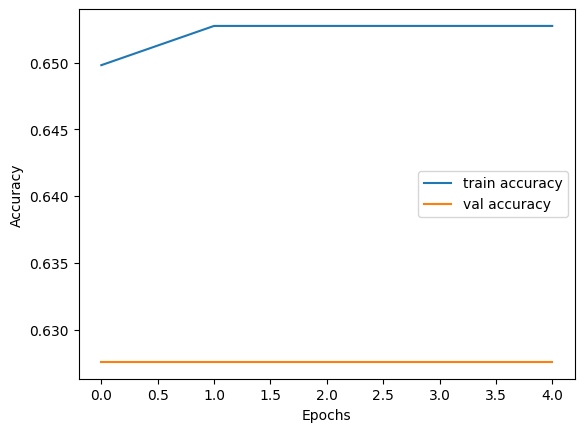

In [ ]:
!pip install tensorflow opencv-python pycocotools roboflow

from google.colab import drive
drive.mount('/content/drive')

import json
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from roboflow import Roboflow

rf = Roboflow(api_key="<roboflow api key>")
project = rf.workspace("imagesegmentation-5fcdp").project("roads-1bztp")
version = project.version(5)
dataset = version.download("coco-segmentation")

annotations_path = "/content/roads-5/train/_annotations.coco.json"
images_path = "/content/roads-5/train"

coco = COCO(annotations_path)
image_ids = coco.getImgIds()

output_images = "/content/processed_images/"
output_masks = "/content/processed_masks/"
os.makedirs(output_images, exist_ok=True)
os.makedirs(output_masks, exist_ok=True)

for image_id in image_ids:
    image_info = coco.loadImgs(image_id)[0]
    image_filename = image_info['file_name']
    image_path = os.path.join(images_path, image_filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)
    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

    for ann in annotations:
        if 'segmentation' in ann:
            segmentation = ann['segmentation']
            if isinstance(segmentation, list):
                for polygon in segmentation:
                    poly = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
                    cv2.fillPoly(mask, [poly], 1)

    cv2.imwrite(os.path.join(output_images, image_filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    mask_filename = image_filename.replace(".jpg", "_mask.png").replace(".png", "_mask.png")
    cv2.imwrite(os.path.join(output_masks, mask_filename), mask)

def load_images_and_masks(image_dir, mask_dir, img_size=(256, 256)):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            img = load_img(os.path.join(image_dir, filename), target_size=img_size)
            img = img_to_array(img) / 255.0
            images.append(img)
            mask_filename = filename.replace(".jpg", "_mask_mask.png")
            mask_path = os.path.join(mask_dir, mask_filename)

            print(f"Checking for mask at: {mask_path}")

            if os.path.exists(mask_path):
                mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
                mask = img_to_array(mask) / 255.0
                masks.append(mask)
            else:
                print(f"Mask for {filename} not found!")

    print(f"Loaded {len(images)} images and {len(masks)} masks.")
    return np.array(images), np.array(masks)

image_dir = "/content/processed_images/"
mask_dir = "/content/processed_masks/"
images, masks = load_images_and_masks(image_dir, mask_dir)

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

def unet(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = models.Model(inputs, outputs)
    return model

model = unet(input_size=(256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=5)
model.save('/content/drive/MyDrive/road_segmentation_unet_model.h5')

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


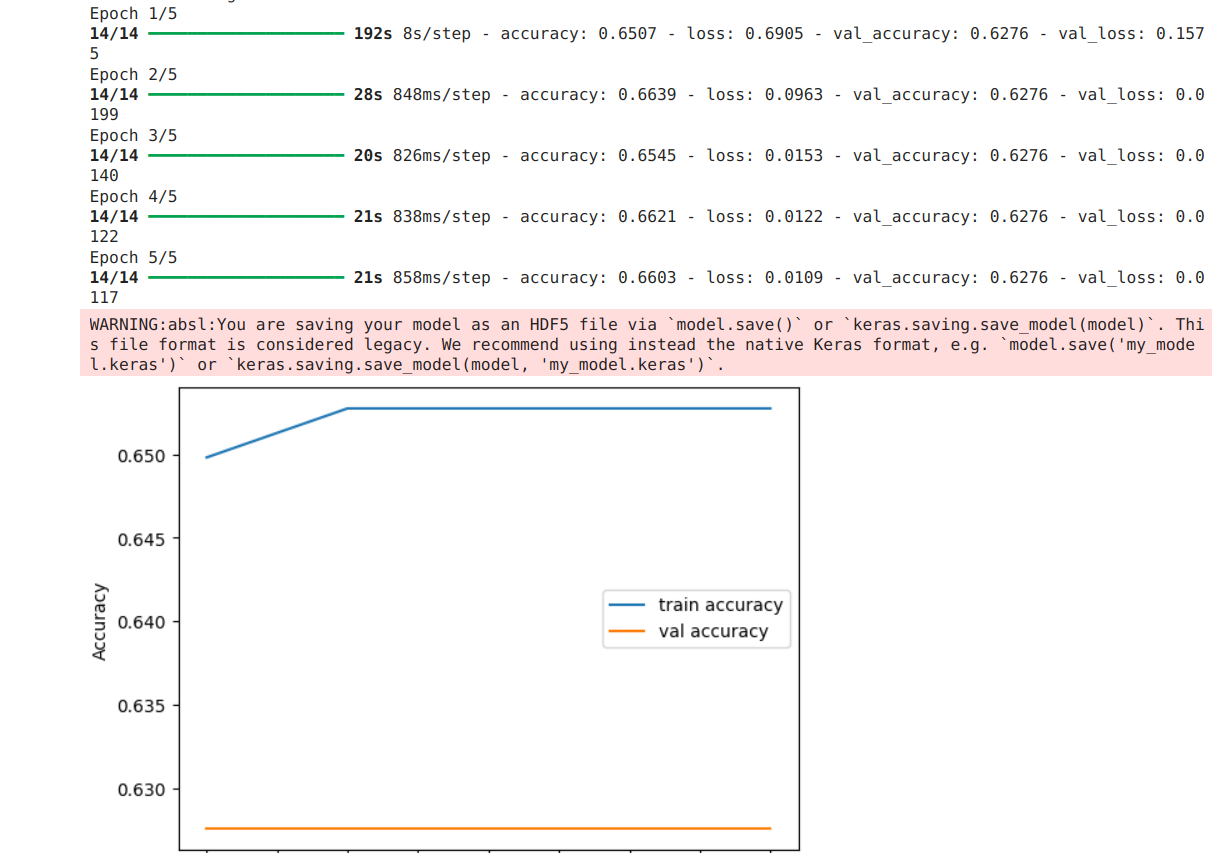

### Observations:
1. **Training Accuracy and Loss:**
   - Training accuracy improves slightly (0.6507 to 0.6603), and loss decreases significantly.

2. **Validation Accuracy and Loss:**
   - Validation accuracy stagnates at ~0.6276 across epochs, while validation loss drops to a very low value, indicating potential overfitting.

3. **Accuracy Plot:**
   - The gap between training and validation accuracy suggests poor generalization.

---

### Analysis:
- **Overfitting:** The model fits the training data well but struggles to generalize, as shown by stagnant validation accuracy.
- **Limited Performance:** Validation accuracy (~62.76%) suggests room for improvement in predictive capability.

---

### Suggestions:
- **Data Augmentation:** Expand the dataset using flipping, rotation, etc.
- **Regularization:** Add dropout or L2 penalties to reduce overfitting.
- **Early Stopping:** Halt training when validation accuracy plateaus.
- **Hyperparameter Tuning:** Optimize learning rate, model architecture, and layer sizes.
- **Dataset Evaluation:** Check for class imbalance or poor data quality.



In [ ]:
# Install   libraries
!pip install tensorflow opencv-python pycocotools roboflow

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')


import json
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from roboflow import Roboflow

rf = Roboflow(api_key="<api key>")
project = rf.workspace("imagesegmentation-5fcdp").project("roads-1bztp")
version = project.version(5)
dataset = version.download("coco-segmentation")

# Set paths to your downloaded dataset
annotations_path = "/content/roads-5/train/_annotations.coco.json"
images_path = "/content/roads-5/train"

# Load COCO annotations and prepare image-mask pairs
coco = COCO(annotations_path)
image_ids = coco.getImgIds()

# Prepare output directories for images and masks
output_images = "/content/processed_images/"
output_masks = "/content/processed_masks/"
os.makedirs(output_images, exist_ok=True)
os.makedirs(output_masks, exist_ok=True)

# Process each image and create binary segmentation masks
for image_id in image_ids:
    image_info = coco.loadImgs(image_id)[0]
    image_filename = image_info['file_name']
    image_path = os.path.join(images_path, image_filename)

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)

    mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    for ann in annotations:
        if 'segmentation' in ann:
            segmentation = ann['segmentation']
            if isinstance(segmentation, list):
                for polygon in segmentation:
                    poly = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
                    cv2.fillPoly(mask, [poly], 1)

    cv2.imwrite(os.path.join(output_images, image_filename), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    mask_filename = image_filename.replace(".jpg", "_mask.png").replace(".png", "_mask.png")
    cv2.imwrite(os.path.join(output_masks, mask_filename), mask)

# Load processed images and masks into arrays
def load_images_and_masks(image_dir, mask_dir, img_size=(256, 256)):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            img = load_img(os.path.join(image_dir, filename), target_size=img_size)
            img = img_to_array(img) / 255.0
            images.append(img)

            mask_filename = filename.replace(".jpg", "_mask_mask.png")
            mask_path = os.path.join(mask_dir, mask_filename)
            if os.path.exists(mask_path):
                mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
                mask = img_to_array(mask) / 255.0
                masks.append(mask)

    return np.array(images), np.array(masks)

image_dir = "/content/processed_images/"
mask_dir = "/content/processed_masks/"
images, masks = load_images_and_masks(image_dir, mask_dir)

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Define the U-Net model
def unet(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Compile and train the model
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=50,
)

# Visualize training results
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
